### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

_This notebook is inspired by the awesome_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _by Berkeley_

For starters, let's define a simple MDP from this picture:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week02_value_based/mdp.py
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfbstart-stop-daemon: unable to stat /usr/bin/Xvfb (No such file or directory)
.


In [2]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [3]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [3]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Optional: Visualizing MDPs

You can also visualize any MDP with the drawing fuction donated by [neer201](https://github.com/neer201).

You have to install graphviz for system and for python. 

1. * For ubuntu just run: `sudo apt-get install graphviz` 
   * For OSX: `brew install graphviz`
2. `pip install graphviz`
3. restart the notebook

__Note:__ Installing graphviz on some OS (esp. Windows) may be tricky. However, you can ignore this part alltogether and use the standart vizualization.

In [4]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


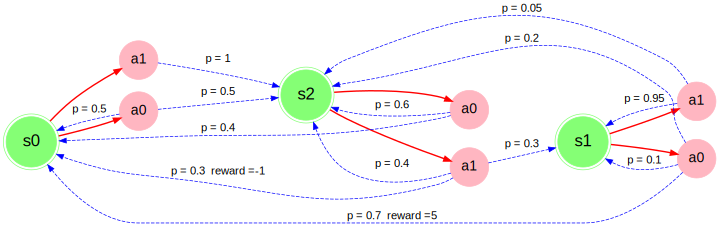

In [5]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is Value Iteration (__VI__)

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

In [6]:
state, action = 's2', 'a1'
next_states = mdp.get_next_states(state, action)

for next_state, prob in next_states.items():
    print(next_state, prob)

s0 0.3
s1 0.3
s2 0.4


In [7]:
mdp.get_reward(state, action, 's0')

-1

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [8]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """
    
    # my code here
    q_action_value = 0
    next_states = mdp.get_next_states(state, action)
    
    for next_state, prob in next_states.items():
        reward = mdp.get_reward(state, action, next_state)
        q_action_value += prob * (reward + gamma * state_values[next_state])
        
    return q_action_value

In [9]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [10]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0
    
    # my code here
    actions = mdp.get_possible_actions(state)
    v_state_value = get_action_value(mdp, state_values, state, actions[0], gamma)
    
    for action in actions[1:]:
        q_action_value_a = get_action_value(mdp, state_values, state, action, gamma)
        v_state_value = max(v_state_value, q_action_value_a)
        
    return v_state_value

In [11]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

Finally, let's combine everything we wrote into a working value iteration algo.

In [12]:
mdp.get_next_states('s2', 'a0')

{'s0': 0.4, 's2': 0.6}

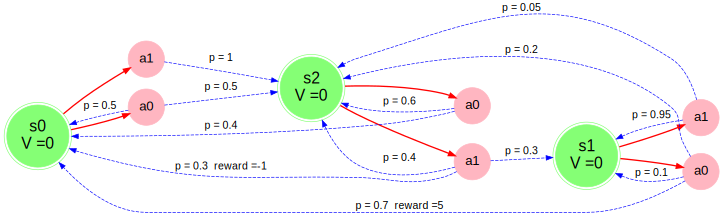

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [13]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

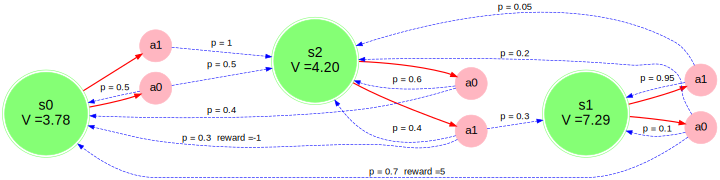

In [14]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [15]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [16]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None
    
    # my code here
    actions = mdp.get_possible_actions(state)
    max_action = actions[0]
    max_Q = get_action_value(mdp, state_values, state, actions[0], gamma)
    
    for action in actions[1:]:
        q_action_value = get_action_value(mdp, state_values, state, action, gamma)
        
        if max_Q < q_action_value:
            max_Q = q_action_value
            max_action = action
        
    return max_action

In [17]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"

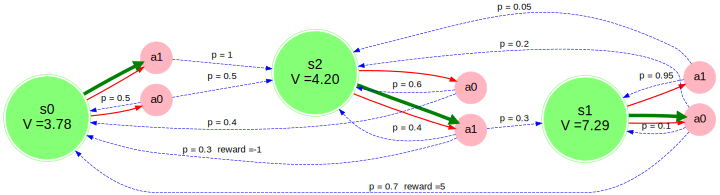

In [18]:
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))

In [19]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4773


### Frozen lake

In [77]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [24]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [79]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 


In [80]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 9
iter    0   |   diff: 0.00000   |   V(start): 0.590 


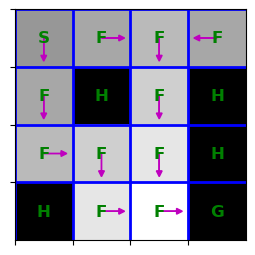

In [82]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
iter    0   |   diff: 0.00000   |   V(start): 0.198 


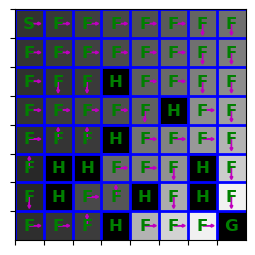

In [74]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [83]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
average reward:  1.0
Well done!


In [84]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

iter    0   |   diff: 0.90000   |   V(start): 0.000 
iter    1   |   diff: 0.72900   |   V(start): 0.000 
iter    2   |   diff: 0.62330   |   V(start): 0.000 
iter    3   |   diff: 0.50487   |   V(start): 0.000 
iter    4   |   diff: 0.40894   |   V(start): 0.000 
iter    5   |   diff: 0.34868   |   V(start): 0.349 
iter    6   |   diff: 0.06529   |   V(start): 0.410 
iter    7   |   diff: 0.05832   |   V(start): 0.468 
iter    8   |   diff: 0.01139   |   V(start): 0.480 
iter    9   |   diff: 0.00764   |   V(start): 0.487 
iter   10   |   diff: 0.00164   |   V(start): 0.489 
iter   11   |   diff: 0.00094   |   V(start): 0.490 
iter   12   |   diff: 0.00022   |   V(start): 0.490 
iter   13   |   diff: 0.00011   |   V(start): 0.490 
iter   14   |   diff: 0.00003   |   V(start): 0.490 
iter   15   |   diff: 0.00001   |   V(start): 0.490 
iter   16   |   diff: 0.00000   |   V(start): 0.490 
average reward:  0.877
Well done!


In [85]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

iter    0   |   diff: 0.75000   |   V(start): 0.000 
iter    1   |   diff: 0.50625   |   V(start): 0.000 
iter    2   |   diff: 0.39867   |   V(start): 0.000 
iter    3   |   diff: 0.26910   |   V(start): 0.000 
iter    4   |   diff: 0.18164   |   V(start): 0.000 
iter    5   |   diff: 0.14013   |   V(start): 0.140 
iter    6   |   diff: 0.07028   |   V(start): 0.199 
iter    7   |   diff: 0.06030   |   V(start): 0.260 
iter    8   |   diff: 0.02594   |   V(start): 0.285 
iter    9   |   diff: 0.01918   |   V(start): 0.305 
iter   10   |   diff: 0.00858   |   V(start): 0.313 
iter   11   |   diff: 0.00560   |   V(start): 0.319 
iter   12   |   diff: 0.00260   |   V(start): 0.321 
iter   13   |   diff: 0.00159   |   V(start): 0.323 
iter   14   |   diff: 0.00076   |   V(start): 0.324 
iter   15   |   diff: 0.00045   |   V(start): 0.324 
iter   16   |   diff: 0.00022   |   V(start): 0.324 
iter   17   |   diff: 0.00012   |   V(start): 0.325 
iter   18   |   diff: 0.00006   |   V(start): 

In [86]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

iter    0   |   diff: 0.80000   |   V(start): 0.000 
iter    1   |   diff: 0.57600   |   V(start): 0.000 
iter    2   |   diff: 0.41472   |   V(start): 0.000 
iter    3   |   diff: 0.29860   |   V(start): 0.000 
iter    4   |   diff: 0.24186   |   V(start): 0.000 
iter    5   |   diff: 0.19349   |   V(start): 0.000 
iter    6   |   diff: 0.15325   |   V(start): 0.000 
iter    7   |   diff: 0.12288   |   V(start): 0.000 
iter    8   |   diff: 0.09930   |   V(start): 0.000 
iter    9   |   diff: 0.08037   |   V(start): 0.000 
iter   10   |   diff: 0.06426   |   V(start): 0.000 
iter   11   |   diff: 0.05129   |   V(start): 0.000 
iter   12   |   diff: 0.04330   |   V(start): 0.000 
iter   13   |   diff: 0.03802   |   V(start): 0.033 
iter   14   |   diff: 0.03332   |   V(start): 0.058 
iter   15   |   diff: 0.02910   |   V(start): 0.087 
iter   16   |   diff: 0.01855   |   V(start): 0.106 
iter   17   |   diff: 0.01403   |   V(start): 0.120 
iter   18   |   diff: 0.00810   |   V(start): 

# HW Part 1: Value iteration convergence

### Find an MDP for which value iteration takes long to converge  (1 pts)

When we ran value iteration on the small frozen lake problem, the last iteration where an action changed was iteration 6--i.e., value iteration computed the optimal policy at iteration 6. Are there any guarantees regarding how many iterations it'll take value iteration to compute the optimal policy? There are no such guarantees without additional assumptions--we can construct the MDP in such a way that the greedy policy will change after arbitrarily many iterations.

Your task: define an MDP with at most 3 states and 2 actions, such that when you run value iteration, the optimal action changes at iteration >= 50. Use discount=0.95. (However, note that the discount doesn't matter here--you can construct an appropriate MDP with any discount.)

Note: value function must change at least once after iteration >=50, not necessarily change on every iteration till >=50.

**Подбор MDP**

Генератор, который считает state-value и action-value функции для заданного MDP. \
Хотим, чтобы оптимальная политика переключалась между $a_0$ и $a_1$. Пусть выплаты будут устроены таким образом, что $Q(s, a_0)$ и $Q(s, a_1)$ были близки. Тогда в какой-то момент при обновлении $V(s) = \max_a Q(s, a)$ политика будет меняться.

In [518]:
gamma = 0.95
v_0, v_1 = 0, 0
p0, p1 = 0.8, 0.4

print(f"it \t| Q(s, a0) \t| Q(s, a1) \t| a0 > a1")

for i in range(100):
    
    # Policy changes for state 0
    q0_a0 = p0 * (10 + gamma * v_0) + (1 - p0) * gamma * v_1
    q0_a1 = p1 * (20 + gamma * v_0) + (1 - p1) * gamma * v_1
    # print(f"{i} | {round(q0_a0, 5)} \t| {round(q0_a1, 5)} \t| {q0_a0 > q0_a1}")
    
    # Policy changes for state 1
    q1_a0 = p0 * (10 + gamma * v_1) + (1 - p0) * gamma * v_0
    q1_a1 = p1 * (20 + gamma * v_1) + (1 - p1) * gamma * v_0
    print(f"{i} \t| {round(q1_a0, 5)} \t| {round(q1_a1, 5)} \t| {q1_a0 > q1_a1}")
    
    # Policy changes for state 2
    q2_a0 = p0 * (10 + gamma * v_1) + (1 - p0) * gamma * v_0
    q2_a1 = p1 * (20 + gamma * v_1) + (1 - p1) * gamma * v_0
    # print(f"{i} \t| {round(q2_a0, 5)} \t| {round(q2_a1, 5)} \t| {q2_a0 > q2_a1}")
    
    # Update state-value function
    v_0 = max(q0_a0, q0_a1)
    v_1 = max(q1_a0, q1_a1)
    v_2 = max(q2_a0, q2_a1)

it 	| Q(s, a0) 	| Q(s, a1) 	| a0 > a1
0 	| 8.0 	| 8.0 	| False
1 	| 15.6 	| 15.6 	| False
2 	| 22.82 	| 22.82 	| False
3 	| 29.679 	| 29.679 	| False
4 	| 36.19505 	| 36.19505 	| False
5 	| 42.3853 	| 42.3853 	| False
6 	| 48.26603 	| 48.26603 	| False
7 	| 53.85273 	| 53.85273 	| True
8 	| 59.16009 	| 59.16009 	| False
9 	| 64.20209 	| 64.20209 	| False
10 	| 68.99199 	| 68.99199 	| False
11 	| 73.54239 	| 73.54239 	| False
12 	| 77.86527 	| 77.86527 	| False
13 	| 81.972 	| 81.972 	| False
14 	| 85.8734 	| 85.8734 	| False
15 	| 89.57973 	| 89.57973 	| False
16 	| 93.10075 	| 93.10075 	| True
17 	| 96.44571 	| 96.44571 	| False
18 	| 99.62342 	| 99.62342 	| False
19 	| 102.64225 	| 102.64225 	| False
20 	| 105.51014 	| 105.51014 	| False
21 	| 108.23463 	| 108.23463 	| False
22 	| 110.8229 	| 110.8229 	| False
23 	| 113.28176 	| 113.28176 	| False
24 	| 115.61767 	| 115.61767 	| False
25 	| 117.83678 	| 117.83678 	| False
26 	| 119.94495 	| 119.94495 	| False
27 	| 121.9477 	| 121.94

In [523]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.8, 's1': 0.2},
        'a1': {'s0': 0.4, 's1': 0.6}
    },
    's1': {
        'a0': {'s0': 0.2, 's1': 0.8},
        'a1': {'s0': 0.6, 's1': 0.4}
    },
    's2': {
        'a0': {'s0': 0.2, 's1': 0.8},
        'a1': {'s0': 0.6, 's1': 0.4}
    }
}
rewards = {
    's0': {'a0': {'s0': 10}, 
           'a1': {'s0': 20}},
    's1': {'a0': {'s1': 10},
           'a1': {'s1': 20}},
    's2': {'a0': {'s1': 10},
           'a1': {'s1': 20}}
}


from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))
# Feel free to change the initial_state

In [524]:
# actions a0 and a1 are equivalent if we don't include the future V(s')
0.4 * 20 == 0.8 * 10

True

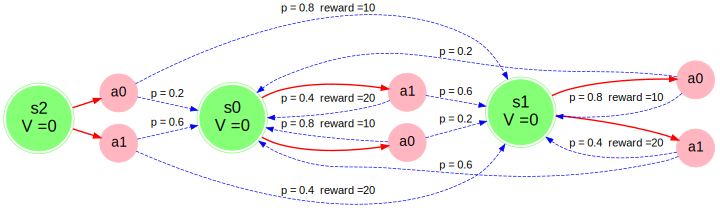

In [525]:
state_values = {s: 0 for s in mdp.get_all_states()}
display(plot_graph_with_state_values(mdp, state_values))

In [539]:
state_values = {s: 0 for s in mdp.get_all_states()}
gamma = 0.95
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])
    
    n_changes = (policy != new_policy).sum()
    if n_changes > 0:
        print("iteration %i, N actions changed = %i" % (i, n_changes))
    policy = new_policy

# please ignore iter 0 at each step

iter    0   |   diff: 8.00000   |   V(start): 8.000 
iter    0   |   diff: 7.20000   |   V(start): 15.200 
iter    0   |   diff: 6.48000   |   V(start): 21.680 
iteration 2, N actions changed = 3
iter    0   |   diff: 5.83200   |   V(start): 27.512 
iteration 3, N actions changed = 3
iter    0   |   diff: 5.24880   |   V(start): 32.761 
iteration 4, N actions changed = 3
iter    0   |   diff: 4.72392   |   V(start): 37.485 
iter    0   |   diff: 4.25153   |   V(start): 41.736 
iteration 6, N actions changed = 3
iter    0   |   diff: 3.82638   |   V(start): 45.563 
iter    0   |   diff: 3.44374   |   V(start): 49.006 
iter    0   |   diff: 3.09936   |   V(start): 52.106 
iter    0   |   diff: 2.78943   |   V(start): 54.895 
iter    0   |   diff: 2.51048   |   V(start): 57.406 
iter    0   |   diff: 2.25944   |   V(start): 59.665 
iter    0   |   diff: 2.03349   |   V(start): 61.699 
iter    0   |   diff: 1.83014   |   V(start): 63.529 
iter    0   |   diff: 1.64713   |   V(start): 65.17

### Value iteration convervence proof (1 pts)
**Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.

Update of value function in value iteration can be rewritten in a form of Bellman operator:

$$(TV)(s) = \max_{a \in \mathcal{A}}\mathbb{E}\left[ r_{t+1} + \gamma V(s_{t+1}) | s_t = s, a_t = a\right]$$

Value iteration algorithm with Bellman operator:

---
&nbsp;&nbsp; Initialize $V_0$

&nbsp;&nbsp; **for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; $V_{k+1} \leftarrow TV_k$

&nbsp;&nbsp;**end for**

---

In [lecture](https://docs.google.com/presentation/d/1lz2oIUTvd2MHWKEQSH8hquS66oe4MZ_eRvVViZs2uuE/edit#slide=id.g4fd6bae29e_2_4) we established contraction property of bellman operator:

$$
||TV - TU||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

Using contraction property of Bellman operator, Banach fixed-point theorem and Bellman equations prove that value function converges to $V^*$ in value iteration.

**Proof:** \
Let $(\mathcal{V}, d)$ be a non-empty complete space with a contraction mapping $T:\mathcal{V} \to \mathcal{V}$. Then $T$ admits a unique fixed-point $V^{*}$ in $\mathcal{V}$ (i.e. $T(V^{*})=V^{*}$). Furthermore, $V^{*}$ can be found as follows: start with an arbitrary element $V_{0}\in \mathcal{V}$ and define a sequence $(V_{k})_{{k\in {\mathbb N}}}$ by $V_{k}=T(V_{k-1})$ for $k\geq 1$. Which is the exact value iteration algorithm. Then $lim _{k\to \infty }V_{k}=V^{*}$.

[Banach_fixed-point_theorem source](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem)

### Asynchronious value iteration (2 pts)

Consider the following algorithm:

---

Initialize $V_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Select some state $s_k \in \mathcal{S}$    

&nbsp;&nbsp;&nbsp;&nbsp; $V(s_k) := (TV)(s_k)$

**end for**

---


Note that unlike common value iteration, here we update only a single state at a time.

**Homework.** Prove the following proposition:

If for all $s \in \mathcal{S}$, $s$ appears in the sequence $(s_0, s_1, ...)$ infinitely often, then $V$ converges to $V*$

**Proof:** Let's split the sequence $(s_0, s_1, ... )$ into subsequences defined as $\mathcal{S}^{k} = (s_0^{k}, s_1^{k}, ...)$, where each $k$ corresponds to a state. This is possible since every state appears in the original sequence infinitely often. \
From the lecture we know that $(TV)(s)$ has a contraction property. Consider setting where $r = r(s_k, a, s_k')$ then for all $V(s_k), U(s_k)$
$$
|(TV)(s_k) - (TU)(s_k)| \le \gamma ||V(s_k) - U(s_k)||_{\infty}.
$$
Now we can apply Banach fixed-point theorem. 
Let $(\mathcal{V_k}, d)$ be a non-empty complete metric space with a contraction mapping $T:\mathcal{V_k} \to \mathcal{V_k}$. 
Then $T$ admits a unique fixed-point $V^{*}(s_k)$ in $\mathcal{V_k}$ (i.e. $TV^{*}(s_k)=V^{*}(s_k)$). 
Furthermore, $V^{*}(s_k)$ can be found as follows: start with an arbitrary element $V_{0}(s_k)\in \mathcal{V_k}$ and define a sequence $(V_{n}(s_k))_{{n\in {\mathbb N}}}$ by $V_{n}(s_k)=TV_{n-1}(s_k)$ for $n\geq 1$. 
Then $lim _{n\to \infty }V_{n}(s_k)=V^{*}(s_k)$. \
Finally, for all $k$ we have $(V^{*}(s_1), V^{*}(s_2), ..., V^{*}(s_k)) = V^{*}$.

# HW Part 2: Policy iteration

## Policy iteration implementateion (3 pts)

Let's implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.


Below are a few helpers that you may or may not use in your implementation.

In [553]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Let's write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.

Unlike VI, this time you must find the exact solution, not just a single iteration.

Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You'll have to solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)

$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$ \
$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s') R(s,\pi(s),s') + \gamma \sum_{s'} P(s,\pi(s),s') V^{\pi}(s')$ \
$V^{\pi}_{[s x 1]} = \sum_{s'}(P \odot R)_{[s x 1]} + \gamma P_{[s x s']} V^{\pi}_{[s' x 1]}$ \
$(I - \gamma P) V^{\pi} = \sum_{s'}(P \odot R)$ \
$A V^{\pi} = B$.


In [292]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    # MY CODE HERE
    states = mdp.get_all_states()
    probs = {s: {s: 0 for s in states} for s in states}
    rewards = {s: {s: 0 for s in states} for s in states}

    for (s, a) in policy.items():
        next_states = mdp.get_next_states(s, a)
        
        for next_s in next_states.keys():
            probs[s][next_s] = mdp.get_transition_prob(s, a, next_s)
            rewards[s][next_s] = mdp.get_reward(s, a, next_s)
            
    probs_matrix = np.array([list(probs[s].values()) for s in sorted(probs.keys())])
    rewards_matrix = np.array([list(rewards[s].values()) for s in sorted(rewards.keys())])
    
    B = (probs_matrix * rewards_matrix).sum(axis=1)
    A = np.identity(probs_matrix.shape[0]) - gamma * probs_matrix
    
    vpi_values = np.linalg.solve(A, B)

    return {s: v for (s, v) in zip(states, vpi_values)}

In [295]:
# test_policy = {s: np.random.choice(
#     mdp.get_possible_actions(s)) for s in mdp.get_all_states()}

test_policy = {'s0': 'a0', 's1': 'a0', 's2': 'a1'}
new_vpi = compute_vpi(mdp, test_policy, gamma=0.95)

print(test_policy)
print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': 'a0', 's1': 'a0', 's2': 'a1'}
{'s0': 6.432568550643525, 's1': 10.086737548964734, 's2': 7.109681029658636}


Once we've got new state values, it's time to update our policy.

In [568]:
mdp.get_possible_actions((1, 1)) == None

False

In [570]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    # MY CODE HERE
    states = mdp.get_all_states()
    actions = mdp.get_possible_actions(states[0])
    q_state_action = {s: {a: 0 for a in actions for s in states} for s in states}
    
    for s in states:
        for a in mdp.get_possible_actions(s):
            next_states = mdp.get_next_states(s, a)
            
            for next_s in next_states.keys():
                prob = mdp.get_transition_prob(s, a, next_s)
                reward = mdp.get_reward(s, a, next_s)

                q_state_action[s][a] += prob * (reward + gamma * vpi[next_s])
    
    new_policy = {}
    for s in states:
        max_q = q_state_action[s][actions[0]]
        max_a = actions[0]
        
        for a in actions[1:]:
            if max_q < q_state_action[s][a]:
                max_q = q_state_action[s][a]
                max_a = a
        # записываем, если это не дыра
        if len(mdp.get_possible_actions(s)) != 0:
            new_policy[s] = max_a
        
    return new_policy

In [325]:
new_policy = compute_new_policy(mdp, new_vpi, gamma=0.95)

print(new_vpi)
print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

{'s0': 6.432568550643525, 's1': 10.086737548964734, 's2': 7.109681029658636}
{'s0': 'a1', 's1': 'a0', 's2': 'a0'}


__Main loop__

In [572]:
def policy_iteration(mdp, policy={}, gamma=0.9, num_iter=1000, min_difference=1e-2):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
    # MY CODE HERE
    
    # Initialization
    state_values = {s: 0 for s in mdp.get_all_states()}
    for s in mdp.get_all_states():
        actions = mdp.get_possible_actions(s)
        if len(actions) > 0:
            policy[s] = np.random.choice(actions)
            
    for i in range(num_iter): 
        # Policy improvement
        vpi = compute_vpi(mdp, policy, gamma)
        new_policy = compute_new_policy(mdp, vpi, gamma)
        
        n_changes = (np.array(list(policy.values())) != np.array(list(new_policy.values()))).sum()
        
        diff = max(abs(state_values[s] - vpi[s]) for s in mdp.get_all_states())
        
        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f  |  N changes: %4i" %
              (i, diff, state_values[mdp._initial_state], n_changes))
        
        policy = new_policy
        state_values = vpi
        if n_changes == 0 or diff < min_difference:
            print("Terminated")
            break

    return state_values, policy

__Your PI Results__

Compare PI and VI on the MDP from bonus 1, then on small & large FrozenLake

__1. Default MDP__

In [484]:
state_values, policy = policy_iteration(mdp, policy={}, gamma=0.9, num_iter=100, min_difference=1e-5)

iter    0   |   diff: 0.89473   |   V(start): 0.000  |  N changes:    2
iter    1   |   diff: 9.54540   |   V(start): -0.732  |  N changes:    1
iter    2   |   diff: 2.22765   |   V(start): 5.804  |  N changes:    0
Terminated


In [488]:
print("PI results:")
print(state_values)
print(policy)

PI results:
{'s0': 8.031919916894893, 's1': 11.171970913211824, 's2': 8.924355463216548}
{'s0': 'a1', 's1': 'a0', 's2': 'a0'}


In [489]:
print("VI results:")
print({'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048})
print({'s0': 'a1', 's1': 'a0', 's2': 'a1'})

VI results:
{'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}
{'s0': 'a1', 's1': 'a0', 's2': 'a1'}


__2. MDP with long convergence__

In [508]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.8, 's1': 0.2},
        'a1': {'s0': 0.4, 's1': 0.6}
    },
    's1': {
        'a0': {'s0': 0.2, 's1': 0.8},
        'a1': {'s0': 0.6, 's1': 0.4}
    },
    's2': {
        'a0': {'s0': 0.2, 's1': 0.8},
        'a1': {'s0': 0.6, 's1': 0.4}
    }
}
rewards = {
    's0': {'a0': {'s0': +10}, 
           'a1': {'s0': +20}},
    's1': {'a0': {'s1': +10},
           'a1': {'s1': +20}},
    's2': {'a0': {'s1': +10},
           'a1': {'s1': +20}}
}


from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))

In [509]:
state_values1_vi = value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5)
policy1_vi = np.array([get_optimal_action(mdp, state_values1_vi, state, gamma)
                           for state in sorted(mdp.get_all_states())])

iter    0   |   diff: 8.00000   |   V(start): 8.000 
iter    1   |   diff: 7.20000   |   V(start): 15.200 
iter    2   |   diff: 6.48000   |   V(start): 21.680 
iter    3   |   diff: 5.83200   |   V(start): 27.512 
iter    4   |   diff: 5.24880   |   V(start): 32.761 
iter    5   |   diff: 4.72392   |   V(start): 37.485 
iter    6   |   diff: 4.25153   |   V(start): 41.736 
iter    7   |   diff: 3.82638   |   V(start): 45.563 
iter    8   |   diff: 3.44374   |   V(start): 49.006 
iter    9   |   diff: 3.09936   |   V(start): 52.106 
iter   10   |   diff: 2.78943   |   V(start): 54.895 
iter   11   |   diff: 2.51048   |   V(start): 57.406 
iter   12   |   diff: 2.25944   |   V(start): 59.665 
iter   13   |   diff: 2.03349   |   V(start): 61.699 
iter   14   |   diff: 1.83014   |   V(start): 63.529 
iter   15   |   diff: 1.64713   |   V(start): 65.176 
iter   16   |   diff: 1.48242   |   V(start): 66.658 
iter   17   |   diff: 1.33417   |   V(start): 67.992 
iter   18   |   diff: 1.20076

In [512]:
state_values1_pi, policy1_pi = policy_iteration(mdp, policy={}, gamma=0.9, num_iter=10, min_difference=1e-5)

iter    0   |   diff: 80.00000   |   V(start): 0.000  |  N changes:    1
iter    1   |   diff: 0.00000   |   V(start): 80.000  |  N changes:    0
Terminated


In [513]:
print("VI results:")
print(state_values1_vi)
print(policy1_vi)

VI results:
{'s0': 79.99991893027061, 's1': 79.99991893027061, 's2': 79.99991893027061}
['a0' 'a0' 'a0']


In [541]:
print("PI results:")
print(state_values1_pi)
print(list(policy1_pi.values()))

PI results:
{'s0': 80.0000000000001, 's1': 80.0000000000001, 's2': 80.00000000000009}
['a0', 'a0', 'a0']


__3. Small FrozenLake MDP__

In [557]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)
mdp.render()

*FFF
FHFH
FFFH
HFFG



In [577]:
state_values2_vi = value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-10)
policy2_vi = np.array([get_optimal_action(mdp, state_values2_vi, state, gamma)
                           for state in sorted(mdp.get_all_states())])

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 


In [578]:
state_values2_pi, policy2_pi = policy_iteration(mdp, policy={}, gamma=0.9, num_iter=10, min_difference=1e-10)

iter    0   |   diff: 1.00000   |   V(start): 0.000  |  N changes:    5
iter    1   |   diff: 0.81000   |   V(start): 0.000  |  N changes:    2
iter    2   |   diff: 0.72900   |   V(start): -0.000  |  N changes:    2
iter    3   |   diff: 0.65610   |   V(start): 0.000  |  N changes:    1
iter    4   |   diff: 0.00000   |   V(start): 0.590  |  N changes:    0
Terminated


VI results:
{(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0}
['down' 'right' 'down' 'left' 'down' None 'down' None 'right' 'down'
 'down' None None 'right' 'right' None]


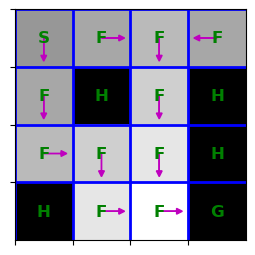

In [587]:
print("VI results:")
print(state_values2_vi)
print(policy2_vi)

draw_policy(mdp, state_values2_vi)

PI results:
{(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0.0, (1, 2): 0.81, (1, 3): 0.0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0.0, (3, 0): 0.0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0.0}
['down', 'right', 'down', 'left', 'down', 'down', 'right', 'down', 'down', 'right', 'right']


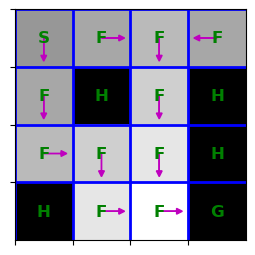

In [588]:
print("PI results:")
print(state_values2_pi)
print(list(policy2_pi.values()))
draw_policy(mdp, state_values2_pi)

__4. Large FrozenLake MDP__

In [589]:
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
mdp.render()

*FFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [590]:
state_values3_vi = value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-10)
policy3_vi = np.array([get_optimal_action(mdp, state_values3_vi, state, gamma)
                           for state in sorted(mdp.get_all_states())])

iter    0   |   diff: 0.90000   |   V(start): 0.000 
iter    1   |   diff: 0.72900   |   V(start): 0.000 
iter    2   |   diff: 0.59049   |   V(start): 0.000 
iter    3   |   diff: 0.47830   |   V(start): 0.000 
iter    4   |   diff: 0.40894   |   V(start): 0.000 
iter    5   |   diff: 0.34868   |   V(start): 0.000 
iter    6   |   diff: 0.29655   |   V(start): 0.000 
iter    7   |   diff: 0.25292   |   V(start): 0.000 
iter    8   |   diff: 0.21619   |   V(start): 0.000 
iter    9   |   diff: 0.18482   |   V(start): 0.000 
iter   10   |   diff: 0.15757   |   V(start): 0.000 
iter   11   |   diff: 0.13430   |   V(start): 0.000 
iter   12   |   diff: 0.11445   |   V(start): 0.000 
iter   13   |   diff: 0.09751   |   V(start): 0.098 
iter   14   |   diff: 0.04772   |   V(start): 0.139 
iter   15   |   diff: 0.03479   |   V(start): 0.173 
iter   16   |   diff: 0.01283   |   V(start): 0.186 
iter   17   |   diff: 0.00734   |   V(start): 0.194 
iter   18   |   diff: 0.00255   |   V(start): 

In [591]:
state_values3_pi, policy3_pi = policy_iteration(mdp, policy={}, gamma=0.9, num_iter=10, min_difference=1e-10)

iter    0   |   diff: 0.94241   |   V(start): 0.000  |  N changes:   37
iter    1   |   diff: 0.79932   |   V(start): 0.000  |  N changes:   16
iter    2   |   diff: 0.30800   |   V(start): 0.152  |  N changes:   12
iter    3   |   diff: 0.18787   |   V(start): 0.154  |  N changes:    9
iter    4   |   diff: 0.10400   |   V(start): 0.166  |  N changes:    1
iter    5   |   diff: 0.05584   |   V(start): 0.198  |  N changes:    1
iter    6   |   diff: 0.01848   |   V(start): 0.198  |  N changes:    0
Terminated


VI results:
{(0, 0): 0.1981684761818299, (0, 1): 0.2223445468143728, (0, 2): 0.24939386588589876, (0, 3): 0.2796305153611386, (0, 4): 0.31337222605793275, (0, 5): 0.3501900597430125, (0, 6): 0.39118770232600264, (0, 7): 0.4341019275245064, (1, 0): 0.20337359652105763, (1, 1): 0.22955579652939892, (1, 2): 0.25934276621637564, (1, 3): 0.2936808680767568, (1, 4): 0.3470339443033557, (1, 5): 0.3904326260130019, (1, 6): 0.4393760035789964, (1, 7): 0.49007888170523783, (2, 0): 0.18924044250472394, (2, 1): 0.2107255842147303, (2, 2): 0.2275230913370816, (2, 3): 0, (2, 4): 0.3707059346733854, (2, 5): 0.41732245390226097, (2, 6): 0.49352220460701646, (2, 7): 0.5533992739104313, (3, 0): 0.20890905452733374, (3, 1): 0.23700151258861346, (3, 2): 0.26918572845430805, (3, 3): 0.30704795134066126, (3, 4): 0.37907154486501793, (3, 5): 0, (3, 6): 0.5553576874758606, (3, 7): 0.625046675774255, (4, 0): 0.18715576498620812, (4, 1): 0.210631583374304, (4, 2): 0.2275188612992404, (4, 3): 0, (4, 4): 0.450931

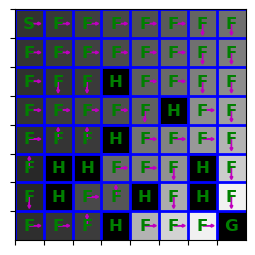

In [594]:
print("VI results:")
print(state_values3_vi)
print(policy3_vi)
draw_policy(mdp, state_values3_vi)

PI results:
{(0, 0): 0.19816847619717398, (0, 1): 0.22234454682008542, (0, 2): 0.24939386588788756, (0, 3): 0.27963051536190003, (0, 4): 0.31337222605820325, (0, 5): 0.35019005974312006, (0, 6): 0.3911877023260406, (0, 7): 0.4341019275245208, (1, 0): 0.20337359653404302, (1, 1): 0.22955579653316943, (1, 2): 0.25934276621763525, (1, 3): 0.2936808680771085, (1, 4): 0.34703394430348516, (1, 5): 0.3904326260130394, (1, 6): 0.43937600357900836, (1, 7): 0.4900788817052414, (2, 0): 0.18924044251784294, (2, 1): 0.2107255842218003, (2, 2): 0.22752309133827528, (2, 3): 0.0, (2, 4): 0.37070593467342344, (2, 5): 0.41732245390227246, (2, 6): 0.49352220460701934, (2, 7): 0.5533992739104322, (3, 0): 0.20890905453672834, (3, 1): 0.2370015125904629, (3, 2): 0.26918572845468425, (3, 3): 0.30704795134066687, (3, 4): 0.3790715448650208, (3, 5): 0.0, (3, 6): 0.5553576874758612, (3, 7): 0.6250466757742553, (4, 0): 0.18715576500334344, (4, 1): 0.21063158338194715, (4, 2): 0.22751886130048193, (4, 3): 0.0, (4

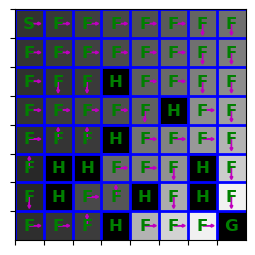

In [593]:
print("PI results:")
print(state_values3_pi)
print(list(policy3_pi.values()))
draw_policy(mdp, state_values3_pi)

## Policy iteration convergence (3 pts)

**Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.

We can define another Bellman operator:

$$(T_{\pi}V)(s) = \mathbb{E}_{r, s'|s, a = \pi(s)}\left[r + \gamma V(s')\right]$$

And rewrite policy iteration algorithm in operator form:


---

Initialize $\pi_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Solve $V_k = T_{\pi_k}V_k$   

&nbsp;&nbsp;&nbsp;&nbsp; Select $\pi_{k+1}$ s.t. $T_{\pi_{k+1}}V_k = TV_k$ 

**end for**

---

To prove convergence of the algorithm we need to prove two properties: contraction an monotonicity.

#### Monotonicity (0.5 pts)

For all $V, U$ if $V(s) \le U(s)$   $\forall s \in \mathcal{S}$ then $(T_\pi V)(s) \le (T_\pi U)(s)$   $\forall s \in  \mathcal{S}$

**Proof:**
Consider setting where $r =r(s, a, s')$. Then
$$
[T_\pi V](s) 
= \mathbb{E}_{s'} [r + \gamma V(s') | s, a \sim \pi(s)] \\
= \mathbb{E}_{s'} [r | s, a]+ \gamma \sum_{s'} p(s'| s, a) V(s') \\
\le \mathbb{E}_{s'} [r | s, a]+ \gamma \sum_{s'} p(s'| s, a) U(s') \\
= [T_\pi U](s).
$$
Monotonicity holds.

#### Contraction (1 pts)

$$
||T_\pi V - T_\pi U||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

**Proof:** Let's rewrite lhs of given inequality
$$
|T_\pi V - T_\pi U| 
= \big|\mathbb{E}_{s'} [r + \gamma V(s') | s, a \sim \pi(s)] - \mathbb{E}_{s'} [r + \gamma U(s') | s, a \sim \pi(s)]\big| \\
= \big|\mathbb{E}_{s'} [r | s, a] + \gamma \sum_{s'} p(s'| s, a) V(s') - \mathbb{E}_{s'} [r | s, a] - \gamma \sum_{s'} p(s'| s, a) U(s')\big| \\
= \gamma \big|\sum_{s'} p(s'| s, a) (V(s') - U(s'))\big| \\
\le \gamma \sum_{s'} p(s'| s, a) \big|V(s') - U(s')\big| \\
= \gamma \mathbb{E}_{s'} [\big|V(s') - U(s')\big| | s, a] \\
\le \gamma \max_{s'} \big|V(s') - U(s')\big| \\
= \gamma ||V - U||_{\infty}.
$$

Finally, taking max over $s'$ we get
$$
||T_\pi V - T_\pi U||_{\infty} = \max_{s'} |T_\pi V - T_\pi U| \le \gamma ||V - U||_{\infty}.
$$
Contraction holds.

#### Convergence (1.5 pts)

Prove that there exists iteration $k_0$ such that $\pi_k = \pi^*$ for all $k \ge k_0$

**Proof:** We know that 
$\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$, where $Q^{\pi_{n}}$ calculated from $V^{\pi_{n}}$ from the following
$$
Q^{\pi_{n}}(s,a) 
= \mathbb{E}_{s'} [r(s, a, s') + \gamma V^{\pi_{n}}(s') | s, a \sim \pi(s)] 
= [T_{\pi_n} V] (s)
$$
Therefore, we know that $Q^{\pi_{n}}$ has a contraction property. Consider $T$ which takes argmax over a from $Q^{\pi_{n}}$. Then we can apply Banach fixed-point theorem on it. \
Let $(\mathcal{P}, d)$ be a non-empty complete space with a contraction mapping $T:\mathcal{P} \to \mathcal{P}$. Then $T$ admits a unique fixed-point $\pi^{*}$ in $\mathcal{P}$ (i.e. $T(\pi^{*})=\pi^{*}$). Furthermore, $\pi^{*}$ can be found as follows: start with an arbitrary element $\pi_{0}\in \mathcal{P}$ and define a sequence $(\pi_{k})_{{k\in {\mathbb N}}}$ by $\pi_{k}=T(\pi_{k-1})$ for $k\geq 1$. Then $lim _{k\to \infty }\pi_{k}=\pi^{*}$. Since the limit exists there is some $k_0$ such that $\pi_k = \pi^*$ for all $k \ge k_0$ by definition of the limit.